<h1 style="color:rgb(0,120,170)">Hands-on AI I</h1>
<h2 style="color:rgb(0,120,170)">Unit 4 &ndash; Logistic Regression as a Door Opener to Deep Learning</h2>

<b>Authors:</b> Brandstetter, Schäfl, Winter, Schörgenhumer<br>
<b>Date:</b> 13-11-2023

This file is part of the "Hands-on AI I" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which might require small code modifications. Most/All of the used functions are imported from the file <code>u4_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u4_utils.py</code> need to be installed.

In this notebook, you will need to install PyTorch. Follow the instructions on https://pytorch.org/get-started/locally/. Note that there is no need to also install the CUDA-version, the CPU-version is sufficient.

In [1]:
# Import pre-defined utilities specific to this notebook.
import u4_utils as u4

# Import additional utilities needed in this notebook.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from itertools import islice
from torchvision.datasets import MNIST
from types import SimpleNamespace

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u4.setup_jupyter()

<h3 style="color:rgb(0,120,170)">Module versions</h3>

As mentioned in the introductory slides, specific minimum versions of Python itself as well as of used modules are recommended.

In [2]:
u4.check_module_versions()

Installed Python version: 3.10 (✓)
Installed numpy version: 1.23.4 (✓)
Installed pandas version: 1.5.1 (✓)
Installed scikit-learn version: 1.1.3 (✓)
Installed matplotlib version: 3.6.2 (✓)
Installed seaborn version: 0.12.1 (✓)
Installed scipy version: 1.9.3 (✓)
Installed torch version: 1.13.0 (✓)


<h1 style="color:rgb(0,120,170)">Linear regression</h1>

Given a dataset $S$ with two variables, $x$ and $y$ (often termed <i>feature</i> and <i>target</i>):

$$S = \{(x_i, y_i)\}_{i=1}^{n}\quad{}\text{with}\quad{}x, y\in{}\mathbb{R}^1$$

We want to find a linear model which best describes the relationship between $x$ and $y$. But before starting to experiment with such a dataset, we have to generate one in the first place. This can be done using <code>get_dataset(...)</code> from <code>u4_utils.py</code>.

<table>
    <tr>
        <th>Parameter</th>
        <th>Value (used in this notebook)</th>
        <th>Description</th>
    </tr>
    <tr>
        <td><code>num_pairs</code></td>
        <td>50</td>
        <td>amount of $(x, y)$ pairs to generate</td>
    </tr>
    <tr>
        <td><code>variance</code></td>
        <td>0.05</td>
        <td>variance within $y$ w.r.t. defining function</td>
    </tr>
</table>

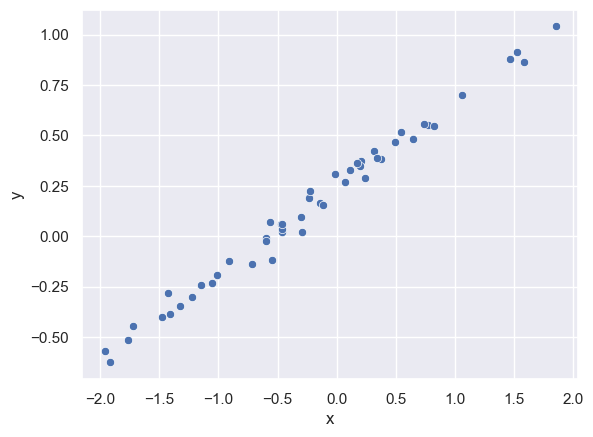

In [3]:
# Set seed for reproducibility.
u4.set_seed(seed=42)

# Create dataset conisting of random (x, y) pairs.
dataset = u4.get_dataset(
    num_pairs=50,
    variance=0.05
    #coefficients=(0.241, 0.422)  # these are the true coefficients used for the data generation
)

sns.scatterplot(data=dataset, x="x", y="y");

We assume that $x$ and $y$ have a <i>linear</i> dependency. Therefore, we select a <i>linear</i> model $g$ with which we want to describe the dataset:

$$g(x; w) = g(x; d, k) = d \cdot x^0 + k \cdot x^1 = d + k \cdot x$$

The function $g(x; d, k)$ will be an approximation of our true labels $y$, as there was an additional <i>variance</i> term involved when generating the features $\{x_i\}_{i=1}^{n}$. All in all there are $2$ unknown parameters $d$ and $k$ (termed <i>intercept</i>/<i>offset</i> and <i>slope</i>, respectively, or polynomial coefficients in the general case), which can be found in various ways. The most simple but rather impractical one is a <i>manual</i> search:

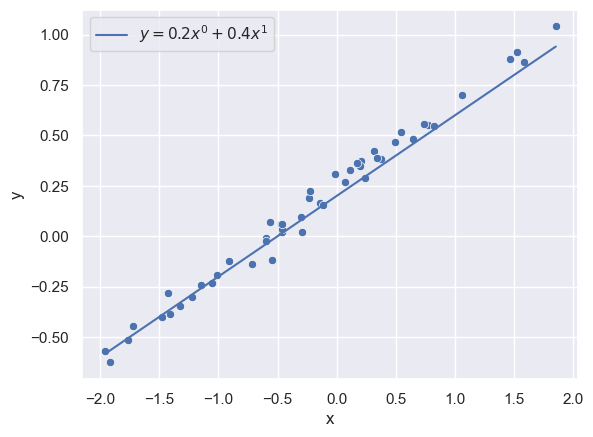

In [4]:
# Manually define coefficients of an underlying linear model (here: a simple straight line, i.e., a polynomial of degree 1).
coefficients = (
    0.2,  # intercept
    0.4   # slope
)

# Plot data pairs as well as the defined linear model.
u4.plot_model(
    dataset=dataset,
    coefficients=coefficients
)

<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Try out different coefficients (intercept and slope). Can you find optimal values for them?</li>
        <li>Change the number of data pairs and the corresponding variance. Are the previously found optimal values still optimal?</li>
    </ul>
</div>

<h2 style="color:rgb(0,120,170)">Find optimal values</h2>
We can automatically (analytically in the linear case) find the optimal values for our intercept $d$ and slope $k$. The idea is to set the parameters in a way that the <b>Mean Squared Error</b> between our linear model and our data pairs is minimized:

$$MSE = \frac{1}{n}\sum_{i=0}^{n}{\left(y_i - g(x_i; d, k)\right)^2} = \frac{1}{n}\sum_{i=0}^{n}{\left(y_i - g(x_i; w)\right)^2}$$

Luckily, there is a **closed-form solution** that only requires a matrix inversion (so we do not have to use iterative methods to minimize the MSE).

In [5]:
coefficients = u4.minimize_mse(
    dataset=dataset,
    degree=1  # just as above, use a polynomial of degree 1, i.e., a straight line
)

print("The coefficients minimizing the MSE are:")
for i, c in enumerate(coefficients):
    print(f"    coefficient {i}: {c}")

The coefficients minimizing the MSE are:
    coefficient 0: 0.2430510869393398
    coefficient 1: 0.42715378227304013


<h3 style="color:rgb(0,120,170)">Background information</h3>
But why do we use the squared error and not, e.g., the absolute error? It turns out that <b>minimizing the squared error is equivalent to maximizing the likelihood P($y_i \mid x_i$)</b> of observing our data (i.e., how plausible the label $y_i$ is given the sample $x_i$ and fixed model parameters). In practice, the negative log-likelihood is minimized. We can use the same minimization algorithm to calculate the optimal parameters for more complicated models.

<br>Next, we load a new dataset by using <code>get_dataset_unknown(...)</code> from <code>u4_utils.py</code> and try to find the model degree which best describes the data.

<table>
    <tr>
        <th>Parameter</th>
        <th>Value (used in this notebook)</th>
        <th>Description</th>
    </tr>
    <tr>
        <td><code>num_pairs</code></td>
        <td>50</td>
        <td>amount of $(x, y)$ pairs to generate</td>
    </tr>
    <tr>
        <td><code>variance</code></td>
        <td>0.9</td>
        <td>variance within $y$ w.r.t. defining function</td>
    </tr>
    <tr>
        <td><code>degree_max</code> (optional)</td>
        <td>6 (default)</td>
        <td>maximum degree of the random underlying polynomial which is used to generate the data</td>
    </tr>
</table>

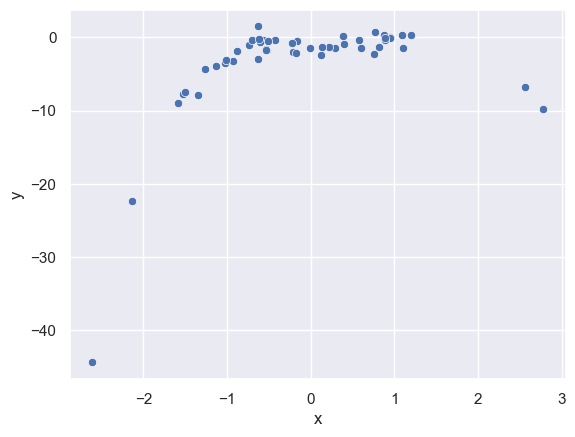

In [6]:
# Set seed for reproducibility.
u4.set_seed(seed=42)

# Create dataset conisting of random (x, y) pairs.
dataset = u4.get_dataset_unknown(
    num_pairs=50,
    variance=0.9
)

sns.scatterplot(data=dataset, x="x", y="y");

In [7]:
coefficients = u4.minimize_mse(
    dataset=dataset,
    degree=5
)

print("The coefficients minimizing the MSE are:")
for i, c in enumerate(coefficients):
    print(f"    coefficient {i}: {c}")

The coefficients minimizing the MSE are:
    coefficient 0: -0.947099162020774
    coefficient 1: 0.042952029663972324
    coefficient 2: -0.09972554986294296
    coefficient 3: 1.1484082145059031
    coefficient 4: -0.5145778175020521
    coefficient 5: -0.01597539871765806


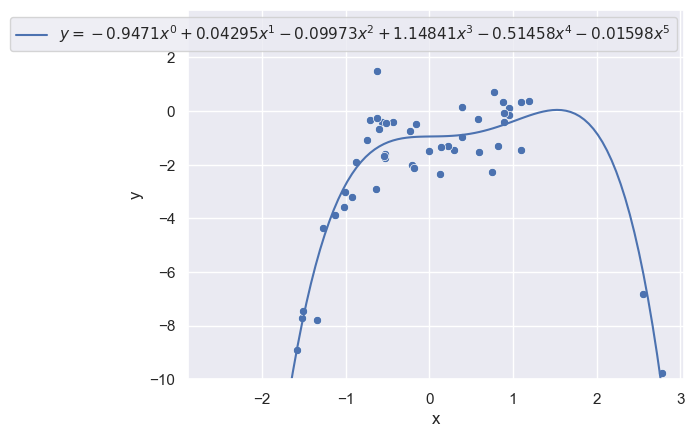

In [8]:
# Plot data pairs as well as the defined linear model.
u4.plot_model(
    dataset=dataset,
    coefficients=coefficients
)

<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Try out different degrees. Can you find a model which seems to be plausibly describing the data?</li>
        <li>Change the upper bound of the randomly chosen degree in the function <code>get_dataset_unknown(...)</code> (parameter <code>degree_max</code>) and repeat the previous experiments. Is it always equally difficult to guess the degree of the polynomial?</li>
    </ul>
</div>

<h2 style="color:rgb(0,120,170)">Over- and underfitting revisited</h2>
Next, we load a dataset with a known degree. We specify the number of samples, the variance of the Gaussian noise and the corresponding coefficients of the underlying model.


<table>
    <tr>
        <th>Parameter</th>
        <th>Value (used in this notebook)</th>
        <th>Description</th>
    </tr>
    <tr>
        <td><code>num_pairs</code></td>
        <td>50</td>
        <td>amount of $(x, y)$ pairs to generate</td>
    </tr>
    <tr>
        <td><code>variance</code></td>
        <td>0.25</td>
        <td>variance within $y$ w.r.t. defining function</td>
    </tr>
     <tr>
        <td><code>coefficients</code></td>
        <td>(0.41, 0.42, 0.43)</td>
        <td>coefficients of the underlying polynomial which is used to generate the data</td>
    </tr>
</table>

What happens if we fit a model with a higher degree polynomial on the data as was used in its generation process?

In [9]:
# Set seed for reproducibility.
u4.set_seed(seed=42)

# Create dataset conisting of random (x, y) pairs.
dataset = u4.get_dataset(
    num_pairs=50,
    variance=0.25,
    coefficients=(0.41, 0.42, 0.43)  # polynomial of degree 2
)

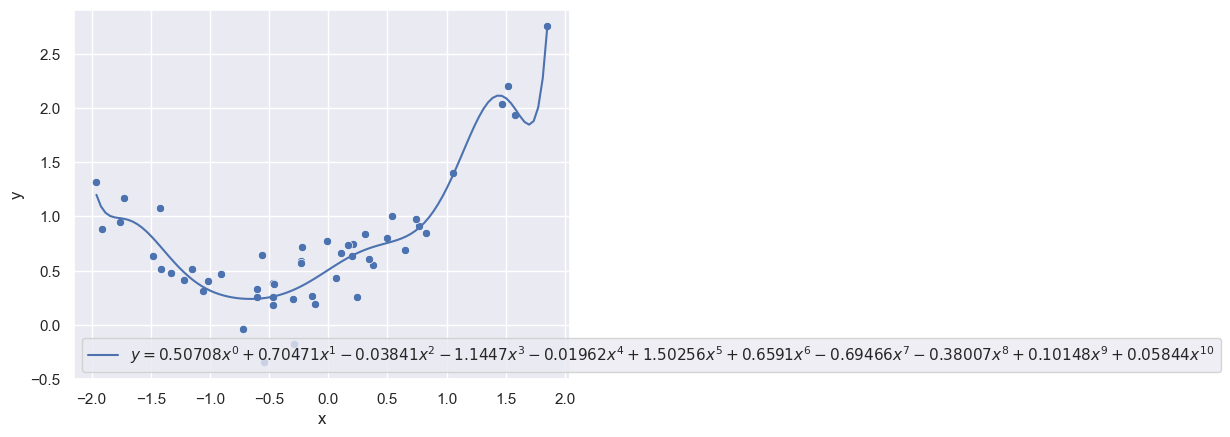

In [10]:
# Minimize mean squared error given a specific degree.
coefficients = u4.minimize_mse(
    dataset=dataset,
    degree=10
)

# Plot data pairs as well as the defined linear model.
u4.plot_model(
    dataset=dataset,
    coefficients=coefficients
)

The more complicated model <b>overfits on the data</b>, desperately trying to describe the random noise. We assume that the model will perform badly on unseen data points. Therefore, we will decrease the model complexity to a degree of 2 again. We follow <b>Occams razor<b>:
    
<cite>The simplest solution is usually the best.</cite>

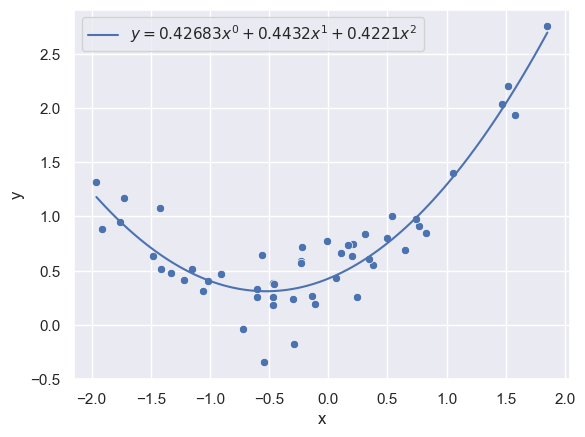

In [11]:
# Minimize mean squared error given a specific degree.
coefficients = u4.minimize_mse(
    dataset=dataset,
    degree=2
)

# Plot data pairs as well as the defined linear model.
u4.plot_model(
    dataset=dataset,
    coefficients=coefficients
)

<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Increase the amount of sample pairs and again fit the higher order polynomial. What happens with the resulting polynomial?</li>
        <li>Change the variance to $0$ and fit a polynomial with degree $2$. Do the found coefficients look familiar?</li>
        <li>Change the variance to $0$ and fit a polynomial with degree $5$. How do the additional coefficients look like?</li>
    </ul>
</div>

<h1 style="color:rgb(0,120,170)">Logistic regression</h1>

Given a dataset $S$ with two variables, $x$ and $y$ (often termed <i>feature</i> and <i>label/class</i>):

$$S = \{(x_i, y_i)\}_{i=1}^{n}\quad{}\text{with}\quad{}x\in{}\mathbb{R}^1,\;y\in{}\{0,1\}$$

We want to find a model which best describes the relationship between $x$ and $y$, i.e., a model which best <i>classifies</i> a sample $x_i$. But before starting to experiment with such a dataset, we have to generate one in the first place. This can be done using <code>get_dataset_logistic(...)</code> from <code>u4_utils.py</code>.

<table>
    <tr>
        <th>Parameter</th>
        <th>Value (used in this notebook)</th>
        <th>Description</th>
    </tr>
    <tr>
        <td><code>num_pairs</code></td>
        <td>50</td>
        <td>amount of $(x, y)$ pairs to generate</td>
    </tr>
</table>

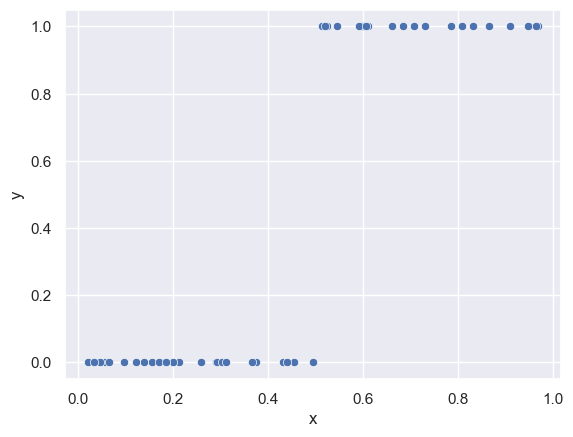

In [12]:
# Set seed for reproducibility.
u4.set_seed(seed=42)

# Create dataset conisting of random (x, y) pairs.
dataset = u4.get_dataset_logistic(
    num_pairs=50
)

sns.scatterplot(data=dataset, x="x", y="y");

What happens if we apply <i>linear regression</i> on a classification task?

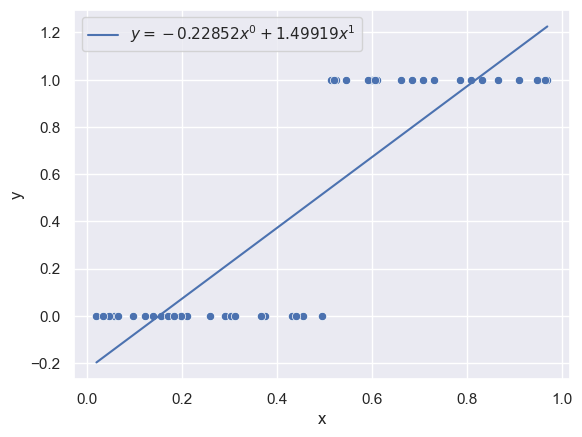

In [13]:
# Minimize mean squared error given a specific degree.
coefficients = u4.minimize_mse(
    dataset=dataset,
    degree=1
)

# Plot data pairs as well as the defined linear model.
u4.plot_model(
    dataset=dataset,
    coefficients=coefficients
)

With a higher order polynomial, the data is fit in a more reasonable way. Nonetheless, we already get the feeling, that this direction might not be the most optimal one.

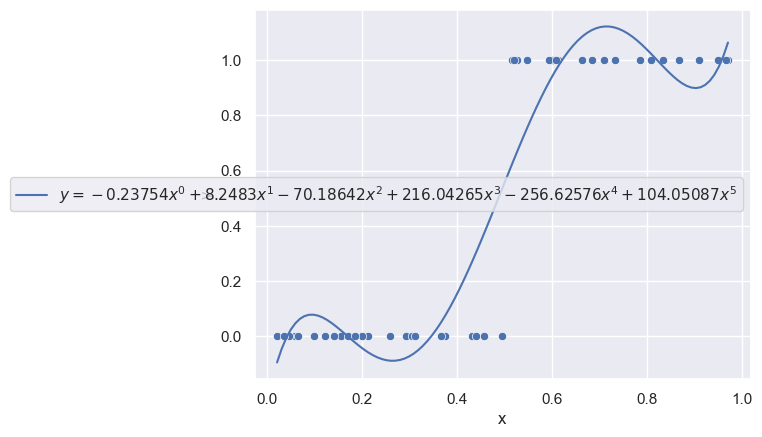

In [14]:
# Minimize mean squared error given a specific degree.
coefficients = u4.minimize_mse(
    dataset=dataset,
    degree=5
)

# Plot data pairs as well as the defined linear model.
u4.plot_model(
    dataset=dataset,
    coefficients=coefficients
)

We will instead use a method specifically designed for categorical data: <b>logistic regression</b>. In addition to our linear regression model, we apply the <b>logistic function</b> $\sigma$ (sigmoid function) to the result of $g\left(x; w{}\right)$.

$$\sigma{}\left(g\left(x; w{}\right)\right) = \frac{1}{1 + \exp{}\left({-g\left(x; w{}\right)}\right)}$$

First, let's define this function in Python:

In [15]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

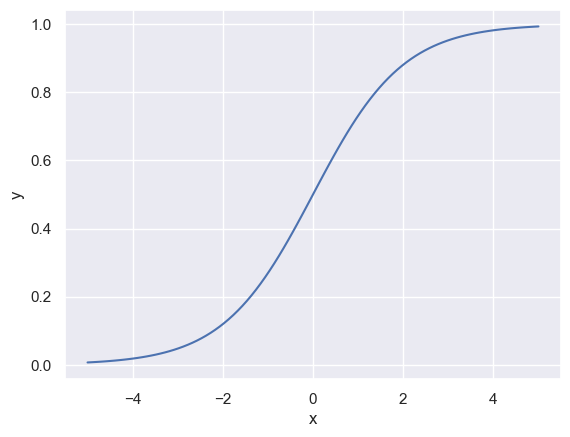

In [16]:
samples = np.linspace(-5.0, 5.0, 100)

ax = sns.lineplot(x=samples, y=sigmoid(samples))
ax.set_xlabel("x")
ax.set_ylabel("y");

<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>What is $\sigma{}\left(x\right)$ for $x\in{}\{-2.5, 2.5, 10.0\}$?</li>
        <li>At which value $x$ is $\sigma{}\left(x\right) = 0$?</li>
    </ul>
</div>

Using the logistic function, we can now efficiently perform classification tasks:

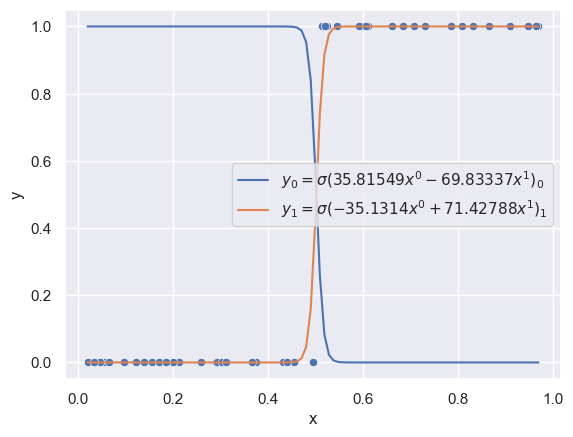

In [17]:
# Set seed for reproducibility.
u4.set_seed(seed=42)

# Create dataset conisting of random (x, y) pairs.
dataset = u4.get_dataset_logistic(
    num_pairs=50
)

# Minimize cross-entropy loss.
coefficients = u4.minimize_ce(
    dataset=dataset,
    iterations=5000,
    learning_rate=10,
    momentum=0.9
)

# Plot data pairs as well as the defined logistic model.
u4.plot_logistic_model(
    dataset=dataset,
    coefficients=coefficients
)

The first (<span style="color:rgb(70,104,164)">blue</span>) line indicates the <b>probability of a sample $x_i$ being class 0</b>. The second (<span style="color:rgb(213,123,80)">orange</span>) line now indicates the <b>probability of a sample $x_i$ being class 1</b>. Note that now there is **no closed-form solution** as in linear regression anymore. Due to the logistic function, our model becomes <i>non-linear</i> and its optimal parameters can <b>only be found via numerical methods</b> (i.e., no analytical solution, we have to use some iterative method instead). In our case, we are using <b>Gradient Descent</b> and instead of the sigmoid function we are actually using the <b>softmax function</b>, which is a general form of the sigmoid function that is able to handle multiple classes $K$:

$$\sigma{}\left(g\left(x; w{}\right)\right)_i = \frac{\exp{}\left(g\left(x; w{}\right)\right)_i}{\sum_{j=1}^{K}{\exp{}\left({g\left(x; w\right)}\right)_j}}$$

and instead of minimizing the MSE loss (function `minimize_mse`), we are now minimizing the <b>Cross Entropy</b> loss (function `minimize_ce(...)`), which is designed for classification and for handling the output such as the one produced by the above softmax function (i.e., probabilities).

<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>What happens if you change the number of iterations and the learning rate?</li>
        <li>What happens if you change the number of samples?</li>
        <li>What happens if you set the learning rate too high?</li>
    </ul>
</div>

You can think of the gradient descent algorithm like <b>a ball rolling down a hill</b>:
- The <i>height</i> of the ball indicates the <i>loss</i> of the model when using the respective parameter value.
- The <i>inertia</i> of the ball indicates the <i>momentum</i>, whereas the (initial) <i>learning rate</i> can be seen as the <i>speed</i> of the ball.
- The <i>space</i> is specified by our parameters. Each model parameter adds a new dimension to the parameter space.

The loss landscape is typically unknown when training a model.

<p style="text-align:center;">
    <img src="resources/loss_landscape.png" alt="loss landscape" width="25%">
    <img src="resources/loss_landscape_local_minimum.png" alt="loss landscape" width="25%">
</p>

<h2 style="color:rgb(0,120,170)">Logistic regression on 2D data</h2>

We now go to a slightly more complex dataset <code>DataSet_LR_a.csv</code>, where the feature vector $\boldsymbol{x}$ consists of two features $x_1$, $x_2$. The labels are again $0$ and $1$ (i.e., a classification task). So let's get started by plotting the new data set:

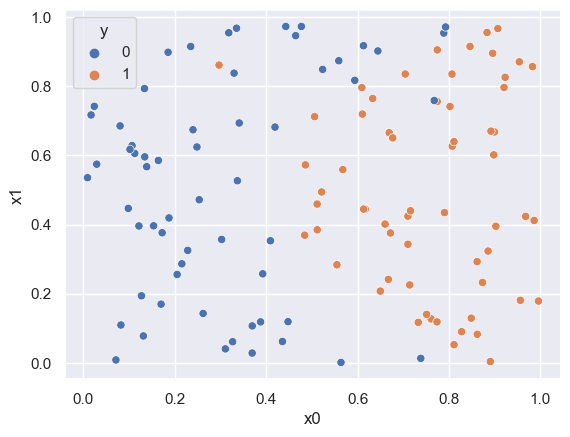

In [18]:
# Load dataset from <*.csv> file.
dataset = u4.get_dataset_from_csv(path='resources/DataSet_LR_a.csv')

sns.scatterplot(data=dataset, x="x0", y="x1", hue="y");

Before fitting a model to the freshly loaded dataset, we have to split it up into <i>two</i> different data sets:
- A <i>training</i> set comprising $50\%$ of the dataset.
- A <i>test</i> set comprising the remaining $50\%$ of the dataset.

In [19]:
# Set seed for reproducibility.
u4.set_seed(seed=42)

# Split dataset into a taining and a test set.
dataset_train = dataset.sample(frac=0.5, replace=False, axis=0)
dataset_test = dataset.drop(dataset_train.index)

We apply the trained model now to our training set (<code>dataset_train</code>) and our test set (<code>dataset_test</code>).

In [20]:
# Minimize cross-entropy loss.
coefficients = u4.minimize_ce(
    dataset=dataset_train,
    iterations=5000,
    learning_rate=10,
    momentum=0.9
)

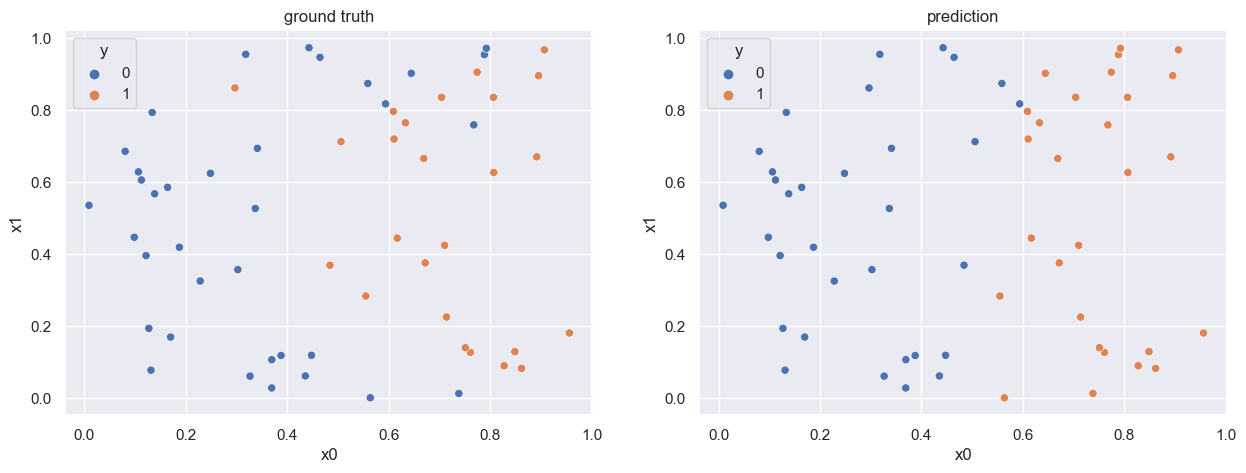

Accuracy on training set: 0.8500


In [21]:
# Plot data pairs as well as the predictions according to the defined logistic model.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot ground truth labels.
axes[0].set_title("ground truth")
sns.scatterplot(data=dataset_train, x="x0", y="x1", hue="y", ax=axes[0])

# Compute predictions of trained logistic regression model w.r.t. the training data.
predictions = u4.predict_logistic(dataset_train.drop(columns="y"), coefficients)

# Plot predicted labels.
axes[1].set_title("prediction")
sns.scatterplot(data=dataset_train.assign(y=predictions), x="x0", y="x1", hue="y", ax=axes[1])
plt.show()

# Compute accuracy given the predicted and the true training labels.
accuracy_train = (predictions == dataset_train["y"]).mean()
print(f"Accuracy on training set: {accuracy_train:.4f}")

<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Plot the test dataset. Does the resulting plot resemble the one of the training data?</li>
        <li>Apply the resulting logistic regression model to the test data. How well does our model perform?</li>
    </ul>
</div>

<h1 style="color:rgb(0,120,170)">PyTorch</h1>

[PyTorch](https://pytorch.org) is a framework to support scientific work and develop corresponding applications. It is typically used to setup, train and apply <i>Artificial Neural Networks (ANNs)</i>. The power of PyTorch (as in several other machine learning centered frameworks) comes with <b>automatic differentation</b>. In this notebook, we will only need the concepts of <b>tensors</b> and of <b>automatic differentation</b>. For this purpose, let us perform some straighforward calculations:

In [22]:
# Set seed for reproducibility.
u4.set_seed(seed=42)

# Generate 3 random numbers according to the uniform distribution U for the interval [0, 1).
x = torch.rand(3)
print(x)

tensor([0.8823, 0.9150, 0.3829])


In [23]:
# Compute the square of the previously generated random numbers.
y = x ** 2
print(y)

tensor([0.7784, 0.8372, 0.1466])


In [24]:
# Compute the (natural) logarithm of the sum of two tensors.
z = torch.log(x + y)
print(z)

tensor([ 0.5072,  0.5609, -0.6359])


PyTorch organizes sets of values in tensors. Tensors can have arbritary numbers of dimensions.
- A tensor with $0$ dimensions is called a <i>scalar</i>.
- A tensor with $1$ dimension is called a <i>vector</i>.
- A tensor with $2$ dimensions is called a <i>matrix</i>.

In [25]:
# Set the shape of the resulting tensor.
shape = (
    2,  # number of elements in level 0; each element has the shape of the remaining levels; here: (3, 4)
    3,  # number of elements in level 1; each element has the shape of the remaining levels; here: (4,)
    4   # number of elements in level 3
)

# We could think of this 3D data as:
#   level 0: number of matrices
#   level 1: number of rows in each matrix
#   level 2: number of elements in each row = number of columns in each matrix
# So here, we create 2 matrices, each of size 3x4 (3 rows, 4 columns)

# Generate a tensor of specified shape according to the normal distribution N(0, 1), i.e., 0 mean, 1 variance.
x = torch.randn(shape)
print(x)

tensor([[[-2.1055,  0.6784, -1.2345, -0.0431],
         [-1.6047,  1.7878, -0.4780, -0.2429],
         [ 0.2415, -1.1109,  0.0915, -2.3169]],

        [[-0.2168, -1.3847, -0.8712, -0.2234],
         [-0.6216, -0.5920, -0.0631, -0.8286],
         [ 0.3309, -1.5576,  0.9956, -0.8798]]])


In [26]:
# Access and print the shape of the previously generated tensor.
print(x.shape)

torch.Size([2, 3, 4])


In [27]:
# Access and print the data type of the previously generated tensor.
print(x.type())

torch.FloatTensor


In [28]:
# Access and print the data type of an element of the previously generated tensor.
print(x.dtype)

torch.float32


In [29]:
# For scalar tensors (only 1 value): Extract the value from the tensor into a plain Python number.
single_element_tensor = torch.rand(1)
print(single_element_tensor)
print(single_element_tensor.item())

tensor([0.9464])
0.9464110732078552


In [30]:
# Create a tensor from existing data.
x = torch.tensor([1.5, 0.4, 0.3])
print(x)

tensor([1.5000, 0.4000, 0.3000])


In [31]:
# Access and print the device on which the previously generated tensor resides on.
print(x.device)

cpu


In [32]:
# Send the previously generated tensor to the GPU with index 0 (if possible).
if torch.cuda.is_available():
    x = x.to("cuda:0")

# Check the current device of the tensor.
print(x.device)

cpu


We can use PyTorch to automatically calculate gradients of a function with respect to some variable.

$$
    \begin{align}
        f\left(x\right) &= \left(2\cdot{}x\right)^7 \\
        f^\prime{}\left(x\right) &= 7\cdot{}\left(2\cdot{}x\right)^6\cdot{}2 \\
        f^\prime{}\left(x\right)\vert{}_{x = 1} &= 896
    \end{align}
$$

In [33]:
# Define the function (with type hints for the parameter and for the return value).
def f(x: torch.Tensor) -> torch.Tensor:
    return (2 * x) ** 7

# Create tensor comprising a single scalar of value 1.
x = torch.ones(1, requires_grad=True)
print(f'x     = {x.item()}')

# Apply the function from above to our created tensor "x".
y = f(x)
print(f'f(x)  = {y.item()}')

# Compute the gradient of this function w.r.t. "x".
dy = torch.autograd.grad(y, x)
print(f"f'(x) = {dy[0].item()}")

x     = 1.0
f(x)  = 128.0
f'(x) = 896.0


This automatic differentiation functionality will turn out as one of the most powerful properties of PyTorch.

<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Implement the function $g\left(x\right) = 42\cdot{}\exp{}\left(\frac{1}{x}\right)$ using PyTorch.</li>
        <li>Compute the gradient of previously defined function $g\left(x\right)$ for $x\in{}\{1, 3, 42\}$ using the automatic differentiation functionality of PyTorch.</li>
    </ul>
</div>

<h1 style="color:rgb(0,120,170)">MNIST dataset</h1>

The [MNIST database (Modified National Institute of Standards and Technology database)](http://yann.lecun.com/exdb/mnist/) is a large database of handwritten digits and is also widely used for training and testing in the field of machine learning. The MNIST database contains $60,000$ images for training and $10,000$ for testing. PyTorch [provides](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) an already pre-processed and adapted version of the MNIST dataset via the <code>torchvision</code> module.

Note: You probably also have to install the Jupyter Widgets, see here: https://ipywidgets.readthedocs.io/en/stable/user_install.html (might require a restart of Jupyter)

In [34]:
mnist_train = MNIST(root="resources", train=True, download=True, transform=None)
mnist_test = MNIST(root="resources", train=False, download=True, transform=None)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting resources/MNIST/raw/train-images-idx3-ubyte.gz to resources/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting resources/MNIST/raw/train-labels-idx1-ubyte.gz to resources/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting resources/MNIST/raw/t10k-images-idx3-ubyte.gz to resources/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting resources/MNIST/raw/t10k-labels-idx1-ubyte.gz to resources/MNIST/raw



The next step is to examine the <i>training</i> and the <i>test</i> sets a little bit closer. For this very reason we first check the number of items in each set (i.e. the amount of <i>samples</i>):

In [35]:
print(len(mnist_train))

60000


In [36]:
print(len(mnist_test))

10000


We can now happily confirm that the loaded training set comprises $60,000$ items whereas the test set $10.000$ – exactly how the MNIST dataset is described. The next step is to look what these items actually are. For that, we print the first item in the MNIST training set:

In [37]:
print(mnist_train[0])

(<PIL.Image.Image image mode=L size=28x28 at 0x126483F70>, 5)


We notice two things:
- A PIL image item within <...>.
- A number.

Hence, an item of the MNIST dataset is clearly a <i>compound data type</i>. To examine which one in particular, we can check the type of the item in question to get more information:

In [38]:
type(mnist_train[0])

tuple

So the compound type of question is a Python <code>tuple</code>. Python tuples present sequences and are <i>immutable</i> Python objects. Hence, they can't be modified in any way after creation (note: the tuples <i>themselves</i>, not necessarily the comprising <i>items</i>). We now use the Python variable assignment convention (i.e., <i>structured binding</i> in this case) to get the image and the integer into two separate Python variables:

In [39]:
image_train, target_train = mnist_train[0]
print(image_train)

<PIL.Image.Image image mode=L size=28x28 at 0x126464280>


As merely seeing <code>&lt;PIL.Image.Image image mode=L size=28x28 at 0x...&gt;</code> doesn't help much in understanding how the image part of an item looks like, we can make use <code>PIL.Image</code> specific properties to actually display the data in a <i>human-readable form:

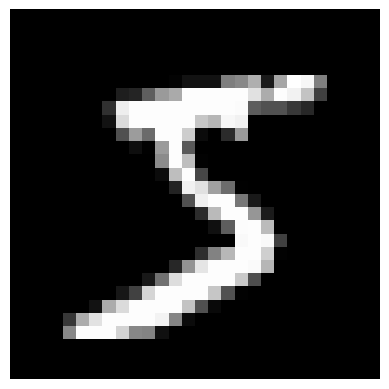

In [40]:
plt.imshow(image_train, cmap='gray')
plt.axis(False)
plt.show()

The displayed data shows an image which does indeed look like the handwritten number <i>five</i>. This is confirmed by checking the content of the accompanying variable <code>target_train</code>. The second part of the tuple therefore turns out to be the corresponding <i>label</i>.

In [41]:
print(target_train)

5


Let's check another item of the MNIST training set, but this time we want to analyze the $42^{nd}$ entry of the test dataset (keep in mind that indexing in Python is <i>zero-based</i>).

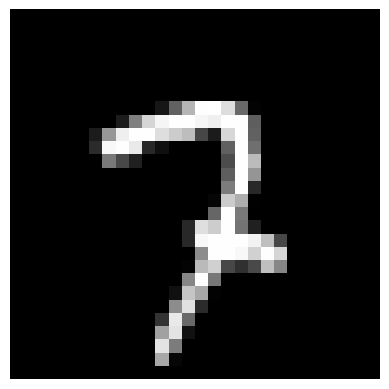

7


In [42]:
image_test, target_test = mnist_test[41]

plt.imshow(image_test, cmap='gray')
plt.axis(False)
plt.show()

print(target_test)

The same behaviour of a dataset item can be confirmed here. Moreover, let's have another look at the data type of both images: 

<h2 style="color:rgb(0,120,170)">Logistic regression on the MNIST dataset</h2>

Before preparing the MNIST data sets and starting the training process we need to set a few hyperparameters:

<table>
    <tr>
        <th>Hyperparameter</th>
        <th>Value (used in this notebook)</th>
    </tr>
    <tr>
        <td><code>batch_size</code></td>
        <td>8</td>
    </tr>
    <tr>
        <td><code>epochs</code></td>
        <td>1</td>
    </tr>
    <tr>
        <td><code>learning_rate</code></td>
        <td>1e-2</td>
    </tr>
    <tr>
        <td><code>momentum</code></td>
        <td>5e-1</td>
    </tr>
</table>

In [43]:
# Set seed for reproducibility.
u4.set_seed(seed=42)

# Set hyperparameters to be used in the training process.
# Note: The "SimpleNamespace(...)" wrapper is just for convenience so we can write "hyperparameters.XYZ", where "XYZ" are our specified variables.
hyperparameters = SimpleNamespace(
    batch_size=8,
    epochs=1,
    learning_rate=1e-2,
    momentum=5e-1
)

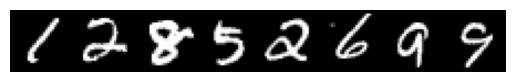

In [44]:
# Load MNIST datasets and encapsulate them in data loaders.
train_loader, test_loader = u4.get_dataset_mnist(
    batch_size=hyperparameters.batch_size
)

# Display the first batch of data and drop the labels (keep only the images themselves).
images = next(islice(train_loader, 1))[0]
# Transform the image shapes for visualization purposes.
images = np.concatenate([img.squeeze() for img in images], axis=1)
# Display the first batch of data.
plt.imshow(images, cmap='gray')
plt.axis(False)
plt.show()

In [45]:
print(train_loader.dataset.data.shape)
print(test_loader.dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [46]:
image_mnist = train_loader.dataset[41][0].squeeze(dim=0).numpy()
input_size = image_mnist.shape[0] * image_mnist.shape[1]  # number of pixel values = 28*28 = 784
output_size = len(train_loader.dataset.classes)  # number of classes = 10
print(f'Input size: {input_size}')
print(f'Output size: {output_size}')

Input size: 784
Output size: 10


In [47]:
# Set seed for reproducibility.
u4.set_seed(seed=42)

# Minimize cross-entropy loss.
coefficients = u4.minimize_ce(
    dataset=train_loader,
    iterations=hyperparameters.epochs,
    learning_rate=hyperparameters.learning_rate,
    momentum=hyperparameters.momentum
)

In [48]:
# Fetch all samples and targets of the MNIST data set and reshape them accordingly.
samples = torch.stack([x for x, y in train_loader.dataset]).flatten(start_dim=1)
targets = train_loader.dataset.targets

# Compute predictions of trained logistic regression model w.r.t. the training data.
predictions = u4.predict_logistic(samples, coefficients)

# Compute accuracy given the predicted and the true training labels.
accuracy_train = (predictions == targets.numpy()).mean()
print(f"Accuracy on training set: {accuracy_train:.4f}")

Accuracy on training set: 0.9125


<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Apply the resulting logistic regression model to the test data. How well does our model perform?</li>
        <li>Modify the hyperparameters and re-train a corresponding model. Can you get a better performance on the test set?</li>
    </ul>
</div>

<h2 style="color:rgb(0,120,170)">Flipping the MNIST dataset</h2>

We now flip the datasets <i>horizontally</i> and <i>vertically</i> and see how the flipping influences the performance of our model. Be sure, to use the <i>previously fitted</i> model.

In [49]:
# Load MNIST datasets and encapsulate them in data loaders.
train_loader, test_loader = u4.get_dataset_mnist(
    batch_size=hyperparameters.batch_size,
    horizontal_flip_p=1.0
)

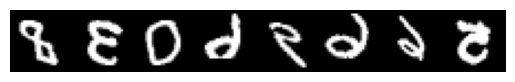

In [50]:
# Display the first batch of data and drop the labels (keep only the images themselves).
images = next(islice(train_loader, 1))[0]
# Transform the image shapes for visualization purposes.
images = np.concatenate([img.squeeze() for img in images], axis=1)
# Display the first batch of data.
plt.imshow(images, cmap='gray')
plt.axis(False)
plt.show()

In [51]:
# Fetch all samples and targets of the MNIST data set and reshape them accordingly.
samples = torch.stack([x for x, y in train_loader.dataset]).flatten(start_dim=1)
targets = train_loader.dataset.targets

# Compute predictions of trained logistic regression model w.r.t. the training data.
predictions = u4.predict_logistic(samples, coefficients)

# Compute accuracy given the predicted and the true training labels.
accuracy_train = (predictions == targets.numpy()).mean()
print(f'Accuracy on training set: {accuracy_train:.4f}')

Accuracy on training set: 0.4349


<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Apply the resulting logistic regression model to the test data. How well does our model perform?</li>
        <li>Try <i>horizontal</i> and <i>vertical</i> flips with different probabilities. How does this influence the performance on the test set?</li>
    </ul>
</div>

<h2 style="color:rgb(0,120,170)">Inverting the test dataset</h2>

We now <i>invert the colors</i> of the datasets (horizontally and vertically flipping is still possible). Be sure, to use the <i>previously fitted</i> model.

In [52]:
# Load MNIST datasets and encapsulate them in data loaders.
train_loader, test_loader = u4.get_dataset_mnist(
    batch_size=hyperparameters.batch_size,
    invert=True
)

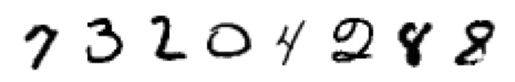

In [53]:
# Display the first batch of data and drop the labels (keep only the images themselves).
images = next(islice(train_loader, 1))[0]
# Transform the image shapes for visualization purposes.
images = np.concatenate([img.squeeze() for img in images], axis=1)
# Display the first batch of data.
plt.imshow(images, cmap='gray')
plt.axis(False)
plt.show()

In [54]:
# Fetch all samples and targets of the MNIST data set and reshape them accordingly.
samples = torch.stack([x for x, y in train_loader.dataset]).flatten(start_dim=1)
targets = train_loader.dataset.targets

# Compute predictions of trained logistic regression model w.r.t. the training data.
predictions = u4.predict_logistic(samples, coefficients)

# Compute accuracy given the predicted and the true training labels.
accuracy_train = (predictions == targets.numpy()).mean()
print(f'Accuracy on training set: {accuracy_train:.4f}')

Accuracy on training set: 0.0975


<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Apply the resulting logistic regression model to the test data. How well does our model perform?</li>
        <li>Try <i>additional</i> horizontal and vertical flips. How does this influence the performance on the test set?</li>
    </ul>
</div>